## Classification of trees in RuneScape

### Rationale

Traditionally there is many types of rewards in RuneScape and focusing on woodcutting seemed like a fun idea. If we can classify trees perhaps we can later do something with this information? Image classification is a type of supervised learning because we know the true positives and true negatives of the classes. Basically our images are already tagged.

### Future Dreams

The idea of reinforcement learning is not to tell the agent everything about the (game) universe. Instead it recognizes a policy that defines rewards from each action. Using simulation inside a private server we can observe episodes on how the agent plays the game. We can't use the real game because we can't easily reset the environment and it would be too slow. We instead can setup a private server and train in the simulated environment. Theoretically after we have a trained agent we can deploy the model to the real game.


Resources used:

1. [Convolutional Neural Networks](https://www.tensorflow.org/tutorials/images/cnn)
2. [Tensorflow images](https://www.tensorflow.org/tutorials/load_data/images)
3. [Tensorflow data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation)
4. [Tensorflow overfitting/underfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)
5. [MemoryError in tensorflow when using nvidia GPU](https://stackoverflow.com/questions/44232898/memoryerror-in-tensorflow-and-successful-numa-node-read-from-sysfs-had-negativ)
6. [Classification of tree species using CNN](https://www.mdpi.com/2072-4292/11/19/2326/htm#B33-remotesensing-11-02326)
7. [Image classification](https://iq.opengenus.org/basics-of-machine-learning-image-classification-techniques/)
8. [IBM Supervised Learning](https://www.ibm.com/cloud/learn/supervised-learning)
9. [IBM Convolutional Neural networks](https://www.ibm.com/cloud/learn/convolutional-neural-networks)
10. [Model tuning](https://machinelearningmastery.com/improve-deep-learning-performance/)
11. [How to determine the filter parameter](https://stackoverflow.com/questions/48243360/how-to-determine-the-filter-parameter-in-the-keras-conv2d-function)


In [2]:
# Import packages
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import PIL
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
import random
import datetime
from math import floor
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report


In [3]:
data_dir = pathlib.Path('images/')
print("Image path:", data_dir)

image_count = len(list(data_dir.glob('*/*.png')))
print("Image count", image_count)


Image path: images
Image count 84


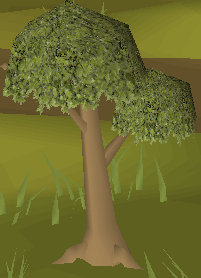

In [4]:
trees = list(data_dir.glob('tree/*'))
PIL.Image.open(str(trees[0]))


### General settings


In [5]:
batch_size = 32     # How many images to feed into the network
img_height = 140    # Image dimensions
img_width = 140
epochs = 20         # How many training rounds to run

# Fun facts if we used traditional fully connected neural networks
trainable_weights = "{0:,}".format((img_height * img_width * 3) ** 2)
print(
    f"We normally would have to train {trainable_weights} weights for a {img_height}x{img_width}x3 image. Thanks to ConvNets we don't have to!")


We normally would have to train 3,457,440,000 weights for a 140x140x3 image. Thanks to ConvNets we don't have to!


In [6]:
def get_image_sets(seed=None):
    # If a seed is not specified pick a random one
    if seed is None:
        seed = floor(random.random() * 500)
    train = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        seed=seed,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )
    validation = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="validation",
        seed=seed,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )
    print("Using seed", seed)
    return train, validation


In [8]:
training_set, validation_set = get_image_sets(420)

class_names = training_set.class_names
print("Classes", class_names)


Found 84 files belonging to 4 classes.
Using 68 files for training.
Found 84 files belonging to 4 classes.
Using 16 files for validation.
Using seed 420
Classes ['oak', 'tree', 'willow', 'yew']


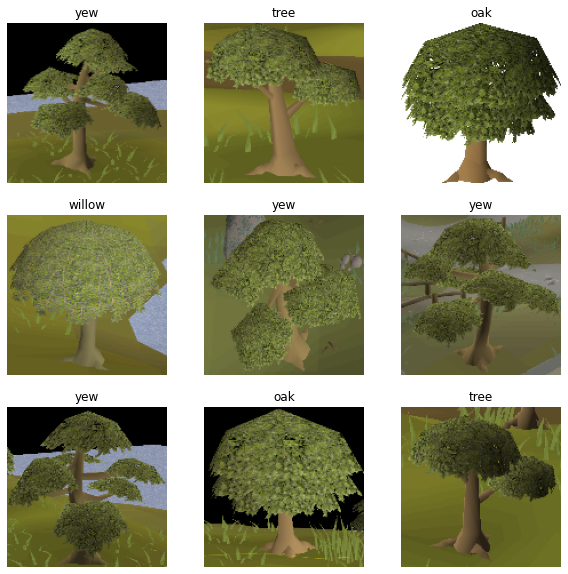

In [9]:
# View samples of the training set
plt.figure(figsize=(10, 10))
for images, labels in training_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [10]:
for image_batch, labels_batch in training_set:
    print(image_batch.shape,
          f'= {batch_size} images with an image resolution of of {img_height}x{img_width}. The images have 3 color channels (RGB)')
    print(labels_batch.shape, f'= {batch_size} labels per batch')
    break

# For performance keep the images in memory after the first epoch
AUTOTUNE = tf.data.AUTOTUNE
training_set = training_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_set = validation_set.cache().prefetch(buffer_size=AUTOTUNE)


(32, 140, 140, 3) = 32 images with an image resolution of of 140x140. The images have 3 color channels (RGB)
(32,) = 32 labels per batch


### Create the convolutional neural network model


In [11]:
def create_model(num_classes, data_augmentation=None):
    '''Use augmented training images otherwise use normal training images '''
    if data_augmentation is not None:
        return Sequential([
            # Augmented images are defined as rescaled and normalized
            data_augmentation,

            # Add the convolution and pooling layers
            layers.Conv2D(filters=64, kernel_size=3,
                          padding='same', activation='relu'),
            layers.MaxPool2D(),
            layers.Conv2D(128, 3, padding='same', activation='relu'),
            layers.MaxPool2D(),
            layers.Conv2D(256, 3, padding='same', activation='relu'),
            layers.MaxPool2D(),

            # Adding more layers doesn't produce significant results
            # layers.Conv2D(512, 3, padding='same', activation='relu'),
            # layers.MaxPool2D(),
            # layers.Conv2D(1024, 3, padding='same', activation='relu'),
            # layers.MaxPool2D(),

            # Dropout layer to prevent over-fitting
            layers.Dropout(0.2),

            # Flatten layer to feed into the fully connected layer
            layers.Flatten(),

            # Fully connected layer
            layers.Dense(128, activation='relu'),

            # Last layer outputs a probability of each class -- Note we are not yet applying the SoftMax function on purpose!
            layers.Dense(num_classes)
        ])

    return Sequential([
        # To rescale an input in the [0, 255] range to be in the [0, 1] https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling
        layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
        # padding same means add padding such that the output length is the same as the input length

        # Add the convolution and pooling layers
        layers.Conv2D(filters=64, kernel_size=3,
                      padding='same', activation='relu'),
        layers.MaxPool2D(),
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.MaxPool2D(),
        layers.Conv2D(256, 3, padding='same', activation='relu'),
        layers.MaxPool2D(),

        # Dropout layer to prevent over-fitting
        layers.Dropout(0.2),

        # Flatten layer to feed into the fully connected layer
        layers.Flatten(),

        # Fully connected layer
        layers.Dense(128, activation='relu'),

        # Last layer outputs a probability of each class -- Note we are not yet applying the SoftMax function on purpose!
        layers.Dense(num_classes)
    ])


In [12]:
num_classes = len(class_names)

# Build the model
model = create_model(num_classes)
model.compile(keras.optimizers.Adam(learning_rate=0.0025),
              # SparseCategoricalCrossentropy from logits tells the loss function that the output values generated by the model are not normalized, a.k.a. logits
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])

# Create a tensorboard callback for later review
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)

# View the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 140, 140, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 140, 140, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 70, 70, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 70, 70, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 35, 35, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 35, 35, 256)       2

In [13]:
train = model.fit(  # Multiple calls to fit will incrementally train the model which can possibly lead the over-fitting
    training_set,
    validation_data=validation_set,
    epochs=epochs,
    # callbacks=[tensorboard_callback]
)


Epoch 1/20


2022-11-29 00:37:56.209234: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600


3/3 [==============================] - 1s 236ms/step - loss: 7.4012 - accuracy: 0.2206 - val_loss: 1.4484 - val_accuracy: 0.3125
Epoch 2/20
3/3 [==============================] - 0s 36ms/step - loss: 1.4380 - accuracy: 0.2647 - val_loss: 1.3930 - val_accuracy: 0.1875
Epoch 3/20
3/3 [==============================] - 0s 23ms/step - loss: 1.3754 - accuracy: 0.2941 - val_loss: 1.4011 - val_accuracy: 0.1875
Epoch 4/20
3/3 [==============================] - 0s 24ms/step - loss: 1.3911 - accuracy: 0.3235 - val_loss: 1.3867 - val_accuracy: 0.2500
Epoch 5/20
3/3 [==============================] - 0s 24ms/step - loss: 1.3266 - accuracy: 0.3235 - val_loss: 1.3381 - val_accuracy: 0.4375
Epoch 6/20
3/3 [==============================] - 0s 24ms/step - loss: 1.2400 - accuracy: 0.4118 - val_loss: 1.4836 - val_accuracy: 0.3750
Epoch 7/20
3/3 [==============================] - 0s 23ms/step - loss: 1.2637 - accuracy: 0.3529 - val_loss: 1.1588 - val_accuracy: 0.3125
Epoch 8/20
3/3 [=====================

### We can visualize the performance of the model using tensorboard


In [14]:
%load_ext tensorboard


In [15]:
# Print all of the available debug values
for h_types in train.history:
    print(h_types)


loss
accuracy
val_loss
val_accuracy


In [16]:
def graph_training_accuracy_n_loss(trained_model):
    acc = trained_model.history['accuracy']
    val_acc = trained_model.history['val_accuracy']

    loss = trained_model.history['loss']
    val_loss = trained_model.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 10))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'Training and Validation Accuracy with {epochs} epochs')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


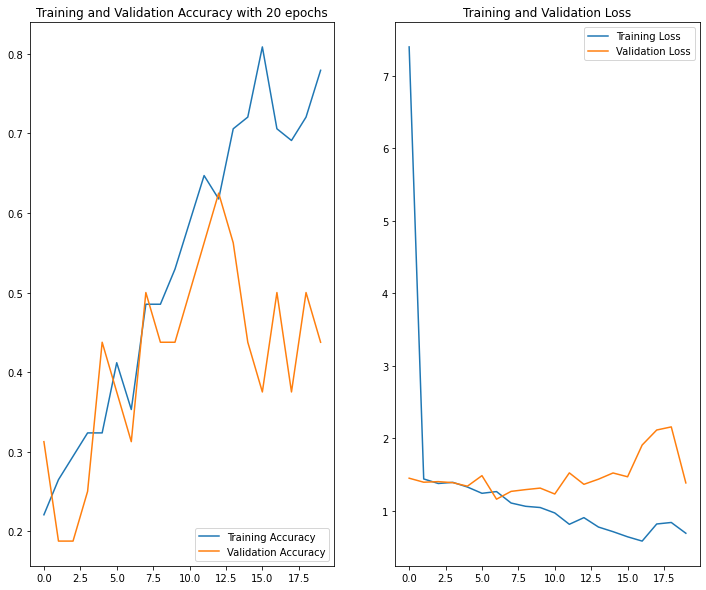

In [17]:
# View the training accuracy and loss
graph_training_accuracy_n_loss(train)


In [18]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical",
                          input_shape=(img_height, img_width, 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)


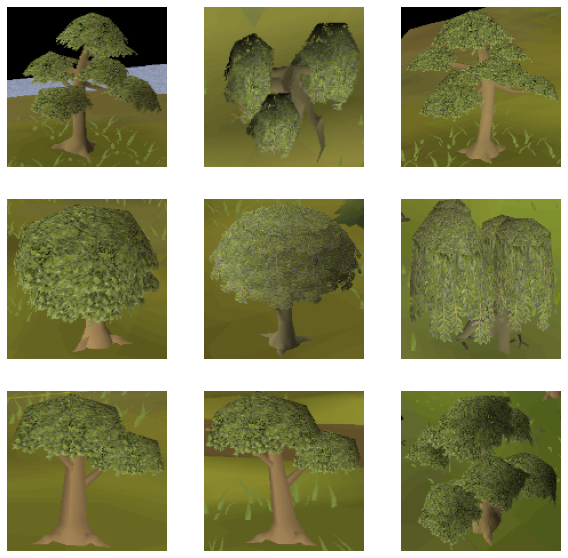

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in training_set.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")


In [20]:
model = create_model(len(class_names), data_augmentation)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 140, 140, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 140, 140, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 70, 70, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 70, 70, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 35, 35, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 35, 35, 256)      

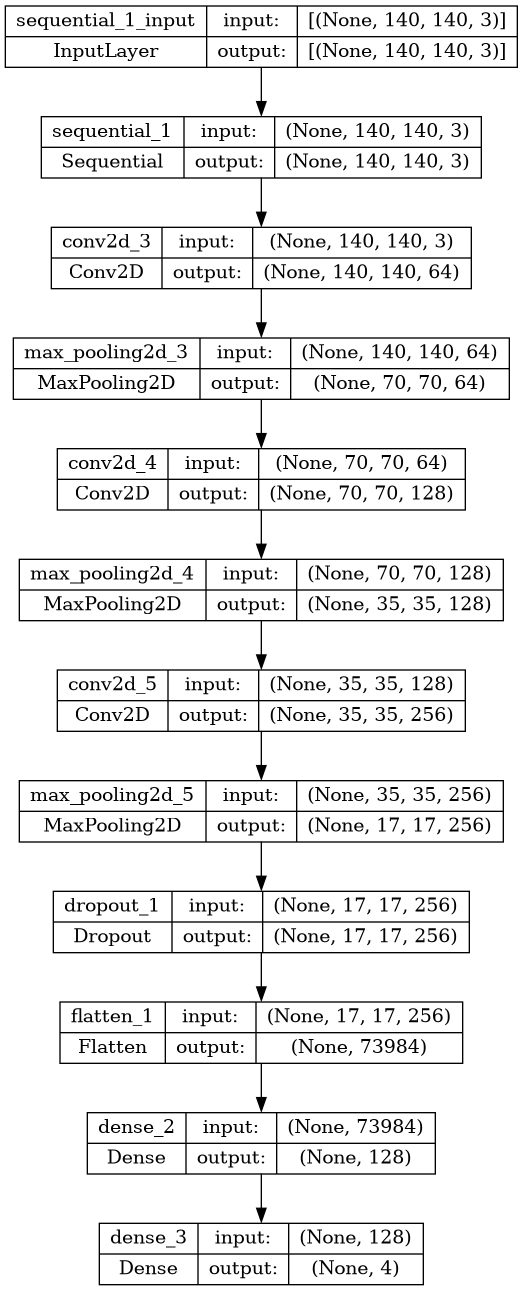

In [21]:
model.compile(keras.optimizers.Adam(learning_rate=0.0001),  # keras.optimizers.RMSprop(1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])
model.summary()

keras.utils.plot_model(model, "new_augmented_model.png", show_shapes=True)


In [22]:
train = model.fit(
    training_set,
    validation_data=validation_set,
    epochs=epochs
)


Epoch 1/20
3/3 [==============================] - 1s 75ms/step - loss: 43.6038 - accuracy: 0.3088 - val_loss: 31.0973 - val_accuracy: 0.3125
Epoch 2/20
3/3 [==============================] - 0s 47ms/step - loss: 50.8306 - accuracy: 0.2353 - val_loss: 19.0209 - val_accuracy: 0.1875
Epoch 3/20
3/3 [==============================] - 0s 28ms/step - loss: 16.5159 - accuracy: 0.3235 - val_loss: 19.2596 - val_accuracy: 0.2500
Epoch 4/20
3/3 [==============================] - 0s 29ms/step - loss: 13.7594 - accuracy: 0.2206 - val_loss: 6.1179 - val_accuracy: 0.4375
Epoch 5/20
3/3 [==============================] - 0s 32ms/step - loss: 5.6225 - accuracy: 0.3088 - val_loss: 9.7034 - val_accuracy: 0.3750
Epoch 6/20
3/3 [==============================] - 0s 28ms/step - loss: 8.0983 - accuracy: 0.3235 - val_loss: 8.7905 - val_accuracy: 0.3125
Epoch 7/20
3/3 [==============================] - 0s 29ms/step - loss: 6.3055 - accuracy: 0.3676 - val_loss: 6.5592 - val_accuracy: 0.4375
Epoch 8/20
3/3 [====

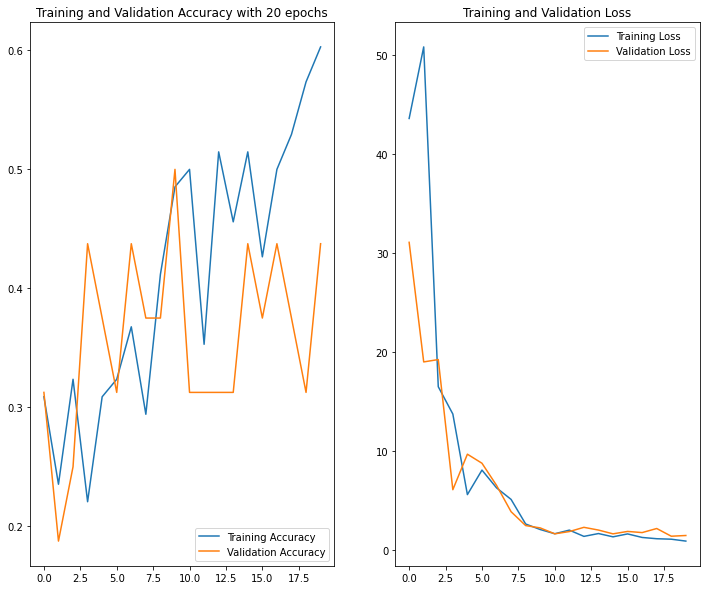

In [23]:
# View the training accuracy and loss
graph_training_accuracy_n_loss(train)


In [24]:
def load_image(image_path):
    return tf.keras.utils.load_img(image_path, target_size=(img_height, img_width))


In [25]:
# Test the trees against unseen data
def classify_unseen_images():
    print("Testing model with unseen images:\n")

    for tree in class_names:
        img = load_image('unseen_images/' + tree + '.png')
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Create a batch
        predictions = model.predict(img_array)

        # Add class names to the predictions
        for p_labels in zip(class_names, predictions[0]):
            print(p_labels, end=" ")

        # Finally apply the softmax to classify the image
        score = tf.nn.softmax(predictions[0])
        print(
            "\nUnseen image of '{}' most likely belongs to {} with a {:.2f} percent confidence.\n"
            .format(tree, class_names[np.argmax(score)], 100 * np.max(score))
        )


In [26]:
def get_actual_predicted_labels(dataset):
    """
      Create a list of actual ground truth values and the predictions from the model.

      Args:
        dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

      Return:
        Ground truth and predicted values for a particular dataset.
    """
    actual = [labels for _, labels in dataset.unbatch()]
    predicted = model.predict(dataset)

    actual = tf.stack(actual, axis=0)
    predicted = tf.concat(predicted, axis=0)
    # If two classes have the same value then we will misclassify them
    predicted = tf.argmax(predicted, axis=1)

    return actual, predicted


In [27]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
    cm = tf.math.confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, annot=True, fmt='g', cmap="YlOrBr", square=True)
    sns.set(rc={'figure.figsize': (8, 8)})
    sns.set(font_scale=1.4)
    ax.set_title('Confusion matrix of recognition ' + ds_type)
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('Actual class')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)


['oak', 'tree', 'willow', 'yew']
Testing model with unseen images:

1/1 [==============================] - 0s 99ms/step
('oak', -1.5532929) ('tree', -1.8067793) ('willow', -5.2494674) ('yew', -3.8671005) 
Unseen image of 'oak' most likely belongs to oak with a 52.64 percent confidence.

1/1 [==============================] - 0s 9ms/step
('oak', -2.323872) ('tree', -3.108286) ('willow', -5.050771) ('yew', -4.566261) 
Unseen image of 'tree' most likely belongs to oak with a 61.42 percent confidence.

1/1 [==============================] - 0s 9ms/step
('oak', -12.20158) ('tree', -14.269903) ('willow', -5.709755) ('yew', -11.369571) 
Unseen image of 'willow' most likely belongs to willow with a 99.48 percent confidence.

1/1 [==============================] - 0s 9ms/step
('oak', -2.4356375) ('tree', 1.8015132) ('willow', -9.516387) ('yew', -1.9229642) 
Unseen image of 'yew' most likely belongs to tree with a 96.28 percent confidence.

3/3 [==============================] - 0s 7ms/step


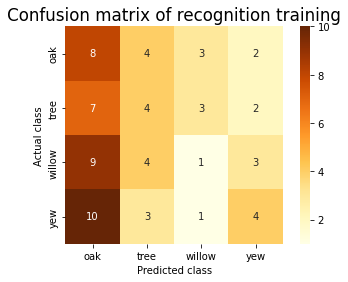

In [28]:
print(class_names)
classify_unseen_images()
actual, predicted = get_actual_predicted_labels(training_set)
plot_confusion_matrix(actual, predicted, class_names, 'training')


3/3 [==============================] - 0s 7ms/step
Classification Report:
----------------------
               precision    recall  f1-score   support

         oak       0.47      0.94      0.63        17
        tree       0.80      0.75      0.77        16
      willow       0.88      0.41      0.56        17
         yew       0.82      0.50      0.62        18

    accuracy                           0.65        68
   macro avg       0.74      0.65      0.65        68
weighted avg       0.74      0.65      0.64        68



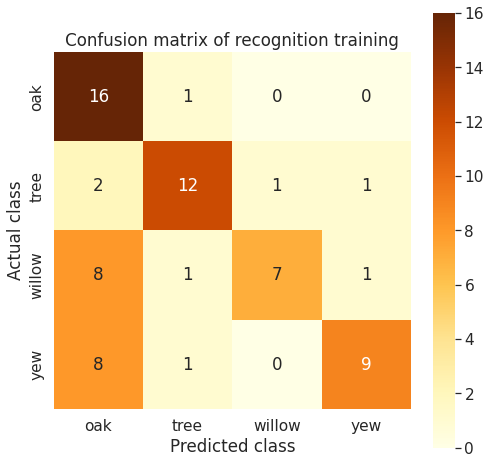

In [34]:
actual, predicted = get_actual_predicted_labels(training_set)
plot_confusion_matrix(actual, predicted, class_names, 'training')
print("Classification Report:\n----------------------\n",
      classification_report(actual, predicted, target_names=class_names))

# The support is the number of occurrences of each class in the training_set
